In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from sklearn import linear_model
from scipy.stats.stats import pearsonr

import os
import sys
import re
import pdb
import glob

sys.path.append('../src')

import utils
from helper_functions import gelx, gely
#import logomaker

# Set other things
%matplotlib inline
plt.ion()
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
# Annotation assisting functions
def get_annotation_df(raw_names, key):
    if ('rep' in key) or ('all' in key):
        annotation_df = pd.DataFrame(columns=['locus', 'lib', 'rep'])
        pattern = re.compile('(?P<locus>\S+)_.*nt' +
                             '_lib(?P<lib_num>[0-9])' +
                             '_rep(?P<rep_num>[0-9])')
        for n, name in enumerate(raw_names):
            m = pattern.match(name)
            if not m:
                raise Exception
                # clean_names.append(name)
                # continue
            locus = m.group('locus')
            if '11nt' in locus:
                locus += ' 11nt'
            lib = 'lib #%s' % str(m.group('lib_num'))
            rep = '%s' % str(m.group('rep_num'))
            locus = locus.upper() #locus[0].upper() + locus[1:]
            annotation_df.loc[n] = {'locus': locus, 'lib': lib, 'rep': rep}
            annotation_spacing = 1

    elif ('lib' in key):
        annotation_df = pd.DataFrame(columns=['locus', 'lib'])
        pattern = re.compile('(?P<locus>\S+)_.*nt' +
                             '_lib(?P<lib_num>[0-9])')
        for n, name in enumerate(raw_names):
            m = pattern.match(name)
            if not m:
                raise Exception
                # clean_names.append(name)
                # continue
            locus = m.group('locus')
            if '11nt' in locus:
                locus += ' 11nt'
            lib = 'lib #%s' % str(m.group('lib_num'))
            locus = locus.upper() #locus[0].upper() + locus[1:]
            annotation_df.loc[n] = {'locus': locus, 'lib': lib}
            annotation_spacing = .4

    elif ('locus' in key):
        annotation_df = pd.DataFrame(columns=['locus'])
        pattern = re.compile('(?P<locus>\S+)_.*nt')
        for n, name in enumerate(raw_names):
            m = pattern.match(name)
            if not m:
                locus = name
            else:
                locus = m.group('locus')
                if '11nt' in locus:
                    locus += ' 11nt'
                locus = locus.upper() #locus[0].upper() + locus[1:]
            annotation_df.loc[n] = {'locus': locus}
            annotation_spacing = .2
    else:
        assert False, 'Error! unparsable raw_names'

    return annotation_df, annotation_spacing


def clean_sample_names(raw_names, key):
    clean_names = []
    if ('rep' in key) or ('all' in key):
        pattern = re.compile('(?P<name>\S+)_.*nt' +
                             '_lib(?P<lib_num>[0-9])' +
                             '_rep(?P<rep_num>[0-9])')
        for name in raw_names:
            m = pattern.match(name)
            if not m:
                clean_names.append(name)
                continue
            name = m.group('name')
            if '11nt' in name:
                name += ' 11nt'
            lib_num = int(m.group('lib_num'))
            rep_num = int(m.group('rep_num'))
            #tmp = name[0].upper() + name[1:]
            tmp = name.upper()
            clean_names.append( \
                '%s (%d.%d)' % (tmp, lib_num, rep_num))
    elif ('lib' in key):
        pattern = re.compile('(?P<name>\S+)_.*nt' +
                             '_lib(?P<lib_num>[0-9])')
        for name in raw_names:
            m = pattern.match(name)
            if not m:
                clean_names.append(name)
                continue
            name = m.group('name')
            if '11nt' in name:
                name += ' 11nt'
            lib_num = int(m.group('lib_num'))
            #tmp = name[0].upper() + name[1:]
            tmp = name.upper()
            clean_names.append( \
                '%s (%d)' % (tmp, lib_num))
    elif ('locus' in key):
        pattern = re.compile('(?P<name>\S+)_.*nt')
        for name in raw_names:
            m = pattern.match(name)
            if not m:
                clean_names.append(name)
                continue
            name = m.group('name')
            if '11nt' in name:
                name += ' 11nt'
            #tmp = name[0].upper() + name[1:]
            tmp = name.upper()
            clean_names.append('%s' % (tmp))
    return clean_names

In [3]:
def plot_9nt_pairwise_effects(ax, effects, feature_names, title='', figsize=[7,6], fontsize=8, clim=[None,None]):

    # Fill effect vector
    effect_vec = pd.DataFrame(index=feature_names)
    effect_vec['value'] = effects
    
    # Fill effect matrix
    all_cols = ['%d%s'%(i,b) for i in range(0,9) for b in bases]
    effect_mat = pd.DataFrame(index=all_cols, columns=all_cols).fillna(0)
    for pair in effect_vec.index:
        pos1, pos2 = pair.split('_')
        effect_mat.loc[pos1,pos2] = effect_vec.loc[pair,'value']
        effect_mat.loc[pos2,pos1] = effect_vec.loc[pair,'value']

    # Create annotation df
    annotation_df = pd.DataFrame(columns=['pos','base'],
                                 data=[[str(i),b] for i in [-3,-2,-1,1,2,3,4,5,6] for b in bases])

    # Plot heatmap
    sns.heatmap(effect_mat.iloc[:,:], ax=ax, vmin=clim[0], vmax=clim[1])

    # Plot gridlines
    for i in range(len(effect_mat)+1):
        if i%4==0:
            ax.axhline(i, color='gray', linewidth=1)
            ax.axvline(i, color='gray', linewidth=1)

    # Annotate x- and y-axes
    gelx(ax, annotation_df, annotation_spacing=1.5, fontsize=fontsize)
    gely(ax, annotation_df.iloc[:,:], annotation_spacing=1.5, fontsize=fontsize)

    # Draw diagonal line
    xs = ax.get_xlim()
    ys = xs[::-1]
    ax.plot(xs, ys, linewidth=2, color='gray')

    from matplotlib.patches import Polygon

#     # Draw masking triangle
#     a = xs[0]
#     b = xs[1]
#     xy = np.array([
#             [a, a],
#             [b, a],
#             [b, b]])
#     triangle = Polygon(xy, closed=True, facecolor='white', zorder=10)
#     ax.add_patch(triangle)

    # Make title
    plt.xlabel(title)

In [4]:
# Load loci
locus_df_file = '../output/ratios_9nt_ss_locus.txt'
locus_df = pd.read_csv(locus_df_file,sep='\t')
locus_df.set_index('ss',inplace=True,drop=True)

# Load libs
lib_df_file = '../output/ratios_9nt_ss_lib.txt'
lib_df = pd.read_csv(lib_df_file,sep='\t')
lib_df.set_index('ss',inplace=True,drop=True)

# Merge loci and libs data
df = locus_df.merge(lib_df, left_index=True, right_index=True)

# Keep only gu splice sites
site_length = len(df.index[0])  
indices = [ss[3:5]=='GU' for ss in df.index]
df = df.loc[indices,:]

In [5]:
# Set consensus sequence
cons_seq = 'CAGGUAAGU'

# Normalize each column by consens sequence value
for col in df.columns:
    df.loc[:,col] = 100*df.loc[:,col]/df.loc[cons_seq,col]

In [6]:
# Compute feature vectors for single positions
bases = 'ACGU'
variable_positions = np.array([0,1,2,5,6,7,8])

features_mat_df = pd.DataFrame(index=df.index)
for i in variable_positions:
    for b in bases:
        col_name = '%d%s'%(i,b)
        features_mat_df.loc[:,col_name] = [float(ss[i]==b) for ss in df.index]

In [7]:
# Compute feature vector for all pairs of positions
features_pair_df = pd.DataFrame(index=features_mat_df.index)
for i in variable_positions:
    for j in variable_positions:
        if j > i:
            for b in bases:
                for c in bases:
                    pos1_col = '%d%s'%(i,b)
                    pos2_col = '%d%s'%(j,c)
                    pair_col = '%s_%s'%(pos1_col,pos2_col)
                    features_pair_df.loc[:,pair_col] = features_mat_df.loc[:,pos1_col]*features_mat_df.loc[:,pos2_col]

In [8]:
coeffs_mat_df = pd.DataFrame(index=features_mat_df.columns)
coeffs_pair_df = pd.DataFrame(index=features_pair_df.columns)
new_df = df.copy()
alphas = np.logspace(-2,8)

# Add predictions to df
# and coefficients to coeffs_df
for dataset_name in df.columns:
    print('Processing %s...'%dataset_name)

    # Set splicing threshold
    splicing_threshod = 20

    # Set measurement data frame
    measurements = df[dataset_name].dropna()

    # Filter for substantial values
    measurements = measurements[measurements >= splicing_threshod]

    # Compute design matrices
    indices = measurements.index
    X_mat = features_mat_df.loc[indices,:]
    X_pair = features_pair_df.loc[indices,:]
    
    # Do linear regression with matrix model
    reg_mat = linear_model.RidgeCV(alphas=alphas)
    reg_mat.fit(X_mat.values, measurements.values)
    print(reg_mat.alpha_)
    
    # Comptue residuals
    residuals = measurements - reg_mat.predict(X_mat)
    
    # Regress pair model against the residuals
    reg_pair = linear_model.RidgeCV(alphas=alphas)
    reg_pair.fit(X_pair, residuals)
    print(reg_pair.alpha_)
    
    # Save predictions 
    col_mat= '%s_mat'%dataset_name
    col_pair= '%s_pair'%dataset_name
    new_df[col_mat] = reg_mat.predict(features_mat_df)
    new_df[col_pair] = reg_pair.predict(features_pair_df) + reg_mat.predict(features_mat_df)
    
    # Save coefficients
    coeffs_mat_df[col_mat] = reg_mat.coef_
    coeffs_pair_df[col_pair] = reg_pair.coef_
    
# for col in coeffs_mat_df.columns:
#     tmp_df = coeffs_mat_df[col]
#     matrix_df = pd.DataFrame(index=[-3, -2, -1, 2, 3, 4, 5],
#                              columns=list(bases), 
#                              data=tmp_df.values.reshape(7,4))
#     matrix_df.index.name = 'pos'
#     file_name = '../plots/parameters_%s.pdf'%col
#     logomaker.make_logo(matrix_df,
#                     fullheight={0:'G',1:'U'},
#                     show_position_zero=False,
#                     vline_positions=[-0.5],
#                     vline_style='--',
#                     vline_width=2,
#                     vline_color='black',
#                     axes_type='vlines',
#                     gridline_alpha=0,
#                     baseline_color='black',
#                     baseline_width=2,
#                     ylabel='effect',
#                     show_binary_yaxis=True,
#                     character_colors='classic',
#                     fullheight_colors='black',
#                     fullheight_boxcolors='white',
#                     fullheight_zorder=20,
#                     title=dataset_name,
#                     save_to_file=file_name,
#                     figsize=[8,3])

Processing brca2_9nt...
2.81176869797
2.81176869797
Processing ikbkap_9nt...
2.81176869797
100000000.0
Processing smn1_9nt...
11.5139539933
47.1486636346
Processing brca2_9nt_lib1...
2.81176869797
2.81176869797
Processing brca2_9nt_lib2...
4.49843266897
1.75751062485
Processing ikbkap_9nt_lib1...
2.81176869797
100000000.0
Processing ikbkap_9nt_lib2...
2.81176869797
100000000.0
Processing smn1_9nt_lib1...
18.4206996933
47.1486636346
Processing smn1_9nt_lib2...
11.5139539933
47.1486636346
Processing smn1_9nt_lib3...
18.4206996933
47.1486636346


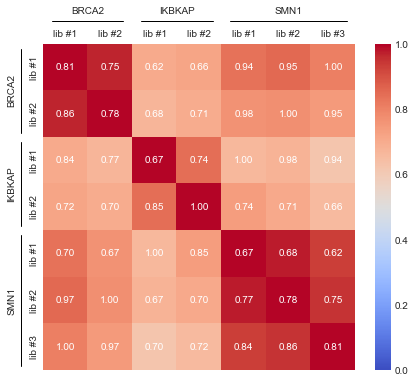

In [26]:
sys.path.append('../src')

import helper_functions
import imp
imp.reload(helper_functions)


# Plot correlations between matrix model parameters, only for lib datasets though
lib_cols = [col for col in coeffs_mat_df.columns if ('_lib' in col)]
coeffs_mat_corr_df = coeffs_mat_df.loc[:,lib_cols].corr()
corr_mat = coeffs_mat_corr_df**2

fig, ax = plt.subplots(figsize=[7,6])
fontsize=10
sns.heatmap(corr_mat, cmap='coolwarm', vmin=0, vmax=1, )
#plt.matshow(corr_mat)

# Create annotation df
annotation_df = get_annotation_df(lib_cols,'lib')[0]

# Annotate x- and y-axes
helper_functions.gelx(ax, annotation_df, annotation_spacing=.5, fontsize=fontsize)
helper_functions.gely(ax, annotation_df, annotation_spacing=.5, fontsize=fontsize)

# Display correlation numbers
num_libs = len(lib_cols)
for i in range(num_libs):
    for j in range(num_libs):
        corr = corr_mat.iloc[i, j]
        if .24 < corr < .62:
            color = 'dimgray'
        else:
            color = 'white'
        plt.text(i + .5, num_libs - j - .5, '%0.2f' % corr,
                 color=color, fontsize=fontsize,
                 horizontalalignment='center',
                 verticalalignment='center')
        
plt.savefig('../plots/parameter_comparison_matrix.pdf')

In [10]:
plt.matshow?

FileNotFoundError: [Errno 2] No such file or directory: 'plots/parameter_comparison_pairwise.pdf'

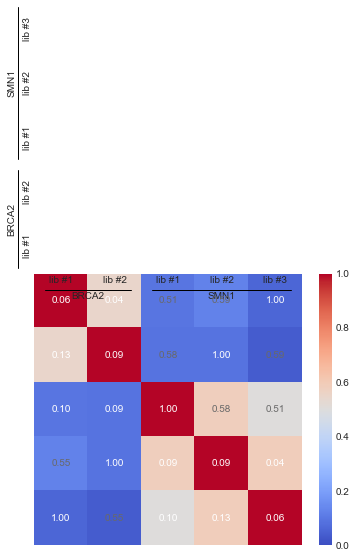

In [11]:
# Plot correlations between pairwise model parameters, only for lib datasets though
lib_cols = [col for col in coeffs_pair_df.columns if ('_lib' in col) and (not 'ikbkap' in col)]
coeffs_pair_corr_df = coeffs_pair_df.loc[:,lib_cols].corr()
corr_mat = coeffs_pair_corr_df**2

fig, ax = plt.subplots(figsize=[6,5])
fontsize=10
sns.heatmap(corr_mat, cmap='coolwarm', vmin=0, vmax=1)

# Create annotation df
annotation_df = get_annotation_df(lib_cols,'lib')[0]

# Annotate x- and y-axes
gelx(ax, annotation_df, annotation_spacing=.3, fontsize=fontsize)
gely(ax, annotation_df, annotation_spacing=.3, fontsize=fontsize)

# Display correlation numbers
num_libs = len(lib_cols)
for i in range(num_libs):
    for j in range(num_libs):
        corr = corr_mat.iloc[i, j]
        if .24 < corr < .75:
            color = 'dimgray'
        else:
            color = 'white'
        plt.text(i + .5, num_libs - j - .5, '%0.2f' % corr,
                 color=color, fontsize=fontsize,
                 horizontalalignment='center',
                 verticalalignment='center')
        
plt.savefig('plots/parameter_comparison_pairwise.pdf')

In [ ]:
for col in df.columns:
    # Create figure and axes
    fig = plt.figure(figsize=[12,7.5])
    ax1 = plt.subplot2grid((2, 3), (0, 0))
    ax2 = plt.subplot2grid((2, 3), (1, 0))
    ax3 = plt.subplot2grid((2, 3), (0, 1), colspan=2, rowspan=2)
    
    lims = [0,150]
    ticks = [0, 50, 100, 150]
    
    col_mat = '%s_mat'%col
    col_pair = '%s_pair'%col
    tmp_df = new_df.loc[:,[col,col_mat,col_pair]]
    tmp_df = tmp_df.dropna(how='any',axis=0)
    
    # Extract rows
    x = tmp_df[col]
    y_mat = tmp_df[col_mat]
    y_pair = tmp_df[col_pair]
    
    indices = x >= splicing_threshod
    
    # Plot matrix model regression
    ax1.plot(x,y_mat,'.')
    r,p = pearsonr(x[indices],y_mat[indices])
    ax1.set_xlabel('measurements')
    ax1.set_ylabel('predictions')
    ax1.set_title('matrix: $R^2 = %0.2f$'%r**2)
    ax1.set_aspect('equal','datalim')
    ax1.set_xlim(lims)
    ax1.set_ylim(lims)
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)
    ax1.axvline(splicing_threshod,linestyle='--')
    
    # Plot matrix + pairwise model regression
    ax2.plot(x,y_pair,'.')
    r,p = pearsonr(x[indices],y_pair[indices])
    ax2.set_xlabel('measurements')
    ax2.set_ylabel('predictions')
    ax2.set_title('matrix + pairwise: $R^2 = %0.2f$'%r**2)
    ax2.set_aspect('equal','datalim')
    ax2.set_xlim(lims)
    ax2.set_ylim(lims)
    ax2.set_xticks(ticks)
    ax2.set_yticks(ticks)
    ax2.axvline(splicing_threshod,linestyle='--')
    
    # Plot pairwise coefficients
    plot_9nt_pairwise_effects(ax=ax3,
                              effects=coeffs_pair_df[col_pair], 
                              feature_names=coeffs_pair_df.index, 
                              title=col,
                              )
    ax3.set_aspect('equal')
    file_name = '../plots/pairwise_%s.pdf' % col
    
    fig.tight_layout(h_pad=2, w_pad=7)
    fig.savefig(file_name)